# Sentiment analysis

In this notebook, the Natural Language Processing pipeline will be build in order to analyse the sentiment of the Tweets.

## Setup the Google Colab environment

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/gdrive')

# Used to interact with directories
import os
# Import Pandas
import pandas as pd
# Import Matplotlib
import matplotlib.pyplot as plt
# Import Datetime
from datetime import datetime 
# Import Numpy 
import numpy as np

# Import ML Dependencies
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

# Import Text Cleaning Dependencies
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Set Seed
np.random.seed(42)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Load the data

To start, let's import the data. A dataset with sentiment labeled Dutch Tweets was downloaded from [Kaggle](https://www.kaggle.com/datasets/skylord/dutch-tweets). This dataset will be used for training our classifiers.

In [ ]:
# Takes all .JSON files in a directory and write it into a single Pandas DataFrame
directory_path = '/gdrive/MyDrive/TwitterData_GroupB/Data/TrainData'

trainData = pd.DataFrame()

# iterate over specified directory
for filename in os.listdir(directory_path):
    # set file path
    file_path = os.path.join(directory_path,filename)
    if os.path.isfile(file_path):
      print(f"Loading: {file_path}.")
      # Read csv into a Pandas DataFrame
      tweets = pd.read_json(file_path)
      # Concatenate tweets from single file to Tweets DataFrame
      trainData = pd.concat([trainData, tweets])

trainData.head()

Mounted at /gdrive
Loading: /gdrive/MyDrive/TwitterData_GroupB/Data/TrainData/dutch_tweets_chunk0.json.
Loading: /gdrive/MyDrive/TwitterData_GroupB/Data/TrainData/dutch_tweets_chunk1.json.
Loading: /gdrive/MyDrive/TwitterData_GroupB/Data/TrainData/dutch_tweets_chunk2.json.
Loading: /gdrive/MyDrive/TwitterData_GroupB/Data/TrainData/dutch_tweets_chunk4.json.
Loading: /gdrive/MyDrive/TwitterData_GroupB/Data/TrainData/dutch_tweets_chunk3.json.
Loading: /gdrive/MyDrive/TwitterData_GroupB/Data/TrainData/dutch_tweets_chunk5.json.
Loading: /gdrive/MyDrive/TwitterData_GroupB/Data/TrainData/dutch_tweets_chunk6.json.
Loading: /gdrive/MyDrive/TwitterData_GroupB/Data/TrainData/dutch_tweets_chunk7.json.
Loading: /gdrive/MyDrive/TwitterData_GroupB/Data/TrainData/dutch_tweets_chunk8.json.
Loading: /gdrive/MyDrive/TwitterData_GroupB/Data/TrainData/dutch_tweets_chunk9.json.


## Clean the training data

We are only interested in the tweet text and sentiment label, so we will drop the other columns.

In [ ]:
trainData = trainData.loc[:, ['full_text', 'sentiment_pattern']]
trainData.head()

,full_text,sentiment_pattern
0,"@pflegearzt @Friedelkorn @LAguja44 Pardon, wol...",0.0
1,RT @grantshapps: Aviation demand is reduced du...,0.0
2,RT @DDStandaard: De droom van D66 wordt werkel...,0.0
3,RT @DDStandaard: De droom van D66 wordt werkel...,0.0
4,De droom van D66 wordt werkelijkheid: COVID-19...,0.0


The tweets have a interval variable for the sentiment label. We want to convert these values into ordinal values that can be used for our classifier. 

In [ ]:
# Make Strings of Tweets
trainData['full_text'] = trainData['full_text'].astype(str)

# Transforming the sentiment scores into five categories
def transform_sentiment(score):
    if score <= -0.6:
        return 'very negative'
    elif score <= -0.2:
        return 'negative'
    elif score <= 0.2:
        return 'neutral'
    elif score <= 0.6:
        return 'positive'
    else:
        return 'very positive'
    
trainData['sentiment_category'] = trainData['sentiment_pattern'].apply(transform_sentiment)
print(trainData['sentiment_category'].value_counts())
trainData.head()

neutral          188664
positive          37758
negative          24386
very positive     10944
very negative      9590
Name: sentiment_category, dtype: int64


,full_text,sentiment_pattern,sentiment_category
0,"@pflegearzt @Friedelkorn @LAguja44 Pardon, wol...",0.0,neutral
1,RT @grantshapps: Aviation demand is reduced du...,0.0,neutral
2,RT @DDStandaard: De droom van D66 wordt werkel...,0.0,neutral
3,RT @DDStandaard: De droom van D66 wordt werkel...,0.0,neutral
4,De droom van D66 wordt werkelijkheid: COVID-19...,0.0,neutral


Visualise imbalance of the dataset

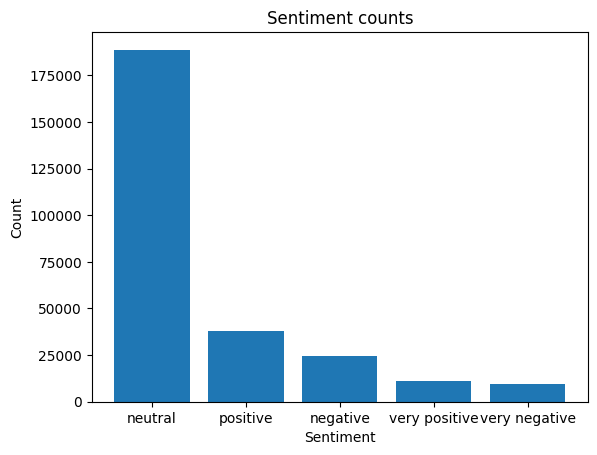

In [ ]:
# Plot Sentiments
sentiment_counts = trainData['sentiment_category'].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values)

# Set Layout
plt.title('Sentiment Counts')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Show Plot
plt.show()

We see that there is a huge imbalance towards neutral tweets in the dataset. This will result in huge bias towards neutral tweets in our models, and therefore our models will be skewed towards this sentiment. As a result, the models will have high accuracy, but will perform badly when it comes to underrepresented sentiment categories in terms of low precision and recall for these categories. Therefore, we will alter the dataset so that each sentimenet category is equally represented.

In [ ]:
def sampleGroup(group):
  return group.sample(9590)

trainData = trainData.groupby('sentiment_category', group_keys=False).apply(sampleGroup)
print(trainData['sentiment_category'].value_counts())


negative         9590
neutral          9590
positive         9590
very negative    9590
very positive    9590
Name: sentiment_category, dtype: int64


Visualise balance.

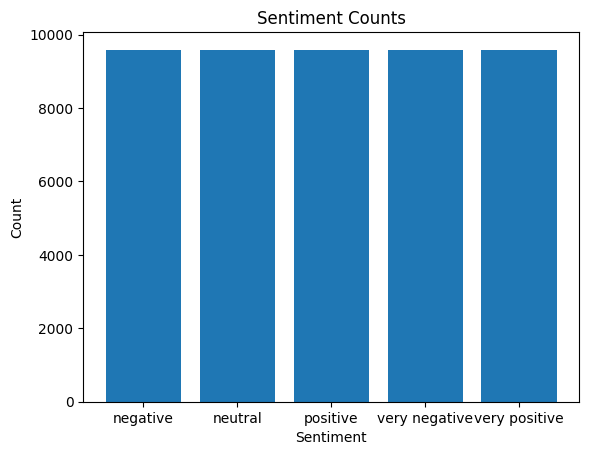

In [ ]:
# Plot Sentiments
sentiment_counts = trainData['sentiment_category'].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values)

# Set Layout
plt.title('Sentiment Counts')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Show Plot
plt.show()

Now that we have prepared our dataset, the tweets that will need to be fed to the models will need to be cleaned. The tweets need to be cleaned to avoid noise and ensure quality input data. Therefore, we need to get rid of links, mentions, punctuations. Second, the tweets need to be tokenized.

In [ ]:
# Cleaning the text data
stemmer = SnowballStemmer("dutch")
stop_words = stopwords.words("dutch")
def clean_text(text):
    # removing URLs
    text = re.sub(r"http\S+", "", text) 
    # removing non-alphabetic characters
    text = re.sub(r"[^a-zA-Z]", " ", text)
    # removing mentions
    text = re.sub(r"@\S+", "", text) 
    # lowercase text
    text = text.lower() 
    # split text into words
    words = text.split() 
    # stemming and removing stop words
    words = [stemmer.stem(word) for word in words if word not in stop_words] 
    # join the cleaned words back into text
    text = " ".join(words) 

    return text

Now we will start training our models. We are intending to first explore two models: Naive Bayes and Random Forest. For all three we will also use cross validation for hyperparameter tuning, in order to get the best classifier possible.

First, we will have to split the training dataset into a training and independent test set. Given that we have a lot of data, we use a 80-20 split.

In [ ]:
# Splitting the dataset into training and testing sets
X_train, X_validation, y_train, y_validation = train_test_split(trainData['full_text'], trainData['sentiment_category'], test_size=0.2, random_state=42)

Check the balance of the training and test set. We see that there is still a small bias towards neutral tweets, but this is okay as the minima and maxima are roughly within 1% of each other for the training set.

In [ ]:
print(y_train.value_counts())
print(y_validation.value_counts())

neutral          7730
positive         7675
very negative    7660
very positive    7652
negative         7643
Name: sentiment_category, dtype: int64
negative         1947
very positive    1938
very negative    1930
positive         1915
neutral          1860
Name: sentiment_category, dtype: int64


Visualise the balance of the sets again.

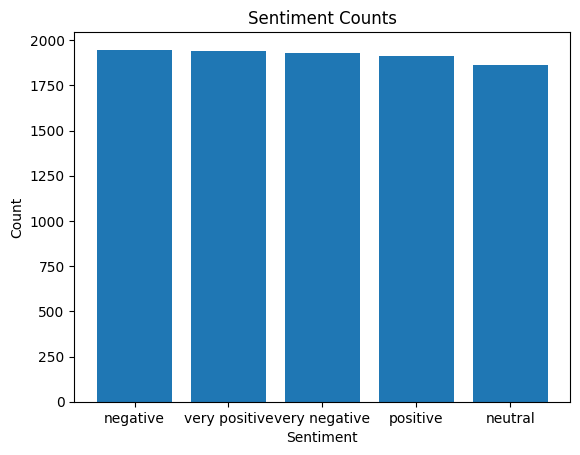

In [ ]:
# Plot Sentiments
sentiment_counts = y_validation.value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values)

# Set Layout
plt.title('Sentiment Counts')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Show Plot
plt.show()

Now we will clean the tweets, using the function as defined earlier.

In [ ]:
# Clean Tweets
X_train = X_train.apply(clean_text)
X_validation = X_validation.apply(clean_text)

In order to feed the tweets to the models, they need to be vectorized, using a vectorizer. The result is a Bag of Words. Every tweet is represented as a vector, which counts the amount of times a word is present in the tweet. 

In [ ]:
# Vectorizing the text data
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_validation)

We want to use Naive Bayes and Random Forest models to explore which one predicts the sentiment of a tweet the best.

In [ ]:
# Creating a dictionary of models to be tested
models = {
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=1000, max_depth=50)
}

## Train the models

Now, we will actually start training the models. We will compare the models based on accuracy, precision, and recall. In addition, we want to have an efficient model so we also take into account computational efficiency.

In [ ]:
# Looping through each model to train and evaluate it
for name, model in models.items():
    print(f"Training and testing {name} model...")
    # Start Timer
    start = datetime.now()
    # Train Model
    model.fit(X_train_vec, y_train)
    # End Timer
    end = datetime.now()
    # Calculate Time Taken
    time_taken = float(f"{(end - start).seconds}.{round((end - start).microseconds, 2)}")

    # Make Predictions
    y_pred = model.predict(X_test_vec)

    # Print Results
    print(f"Training time: {time_taken} seconds")
    print(f"Accuracy score for {name} model: {accuracy_score(y_validation, y_pred)}")
    print(f"Classification report for {name} model:\n{classification_report(y_validation, y_pred)}")
    print(f"Confusion matrix for {name} model:\n{confusion_matrix(y_validation, y_pred)}")

Training and testing Naive Bayes model...
Training time: 0.134546 seconds
Accuracy score for Naive Bayes model: 0.6397288842544318
Classification report for Naive Bayes model:
               precision    recall  f1-score   support

     negative       0.55      0.79      0.65      1947
      neutral       0.59      0.35      0.44      1860
     positive       0.56      0.77      0.65      1915
very negative       0.79      0.67      0.72      1930
very positive       0.82      0.61      0.70      1938

     accuracy                           0.64      9590
    macro avg       0.66      0.64      0.63      9590
 weighted avg       0.66      0.64      0.63      9590

Confusion matrix for Naive Bayes model:
[[1530  104  185  104   24]
 [ 528  659  418  166   89]
 [ 202   93 1480   35  105]
 [ 381  112  110 1292   35]
 [ 126  150  449   39 1174]]
Training and testing Random Forest model...
Training time: 143.428425 seconds
Accuracy score for Random Forest model: 0.6941605839416058
Classifi

Now we will start our hyperparameter tuning for the models. We begin with the Naive Bayes model. We use the alpha hyperparameter, which can be tuned in order to reduce bias and variance.

In [ ]:
# Define Parameter Grid
param_grid = {
    'alpha': [0.75, 1.0, 1.25, 1.5, 1.75, 2.0], # Smoothing parameter
    'fit_prior': [True, False], # Whether to learn class prior probabilities or not
}

# Define Model
nb = MultinomialNB()

# Define Grid Search
grid_search = GridSearchCV(estimator=nb, param_grid=param_grid, cv=5, scoring='accuracy')
# Fit Grid Search
grid_search.fit(X_train_vec, y_train)

# Print Best Parameters
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Best parameters: {'alpha': 0.75, 'fit_prior': True}
Best score: 0.628910323253389


Let's use test these hyperparameter values on our test set and see the results. We can see that our model has an accuracy of 65%, which is not very high but also not very low. Its main flaws is in the neutral category, where we see that it has a low recall score. It does a good job in classifying very positive and negative tweets.

In [ ]:
# Fit Model
nb_model = MultinomialNB(alpha=0.75, fit_prior=True)
nb_model.fit(X_train_vec, y_train)
# Precit Test Set
y_pred = nb_model.predict(X_test_vec)

# Check Metrics
print(f"Accuracy score for Naive Bayes model: {accuracy_score(y_validation, y_pred)}")
print(f"Classification report for Naive Bayes model:\n{classification_report(y_validation, y_pred)}")
print(f"Confusion matrix for Naive Bayes model:\n{confusion_matrix(y_validation, y_pred)}")

Accuracy score for Naive Bayes model: 0.6448383733055266
Classification report for Naive Bayes model:
               precision    recall  f1-score   support

     negative       0.56      0.78      0.65      1947
      neutral       0.58      0.36      0.44      1860
     positive       0.56      0.77      0.65      1915
very negative       0.79      0.69      0.74      1930
very positive       0.82      0.62      0.71      1938

     accuracy                           0.64      9590
    macro avg       0.66      0.64      0.64      9590
 weighted avg       0.66      0.64      0.64      9590

Confusion matrix for Naive Bayes model:
[[1514  111  185  114   23]
 [ 506  668  421  173   92]
 [ 196  105 1468   37  109]
 [ 347  110  101 1337   35]
 [ 121  151  428   41 1197]]


Now let's do the same for the random forest model.

In [ ]:
# Define Parameter Grid
param_grid = {
    'n_estimators': [500, 750, 1000],
    'max_depth': [25, 50, 75],
}

# Fit Model
rf = RandomForestClassifier()

# Create Cross Validation
grid_search2 = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search2.fit(X_train_vec, y_train)

# Print Best Parameters & Accuracy
print(f"Best parameters: {grid_search2.best_params_}")
print(f"Best score: {grid_search2.best_score_}")

KeyboardInterrupt: ignored

Using these hyperparameter on our test set. 

Comment: The CV worked once, but as output gave a best model with an accuracy of 60%, which is worse than the initial model. Than I tried running a new CV, but that one stopped again. Therefore I chose to use the initial model instead.

In [ ]:
# Fit Model
rf_model = RandomForestClassifier(n_estimators=750, max_depth=75)
rf_model.fit(X_train_vec, y_train)

# Predict Test Set
y_pred_rf = rf_model.predict(X_test_vec)

# Check Metrics
print(f"Accuracy score for model: {accuracy_score(y_validation, y_pred_rf)}")
print(f"Classification report for model:\n{classification_report(y_validation, y_pred_rf)}")
print(f"Confusion matrix for model:\n{confusion_matrix(y_validation, y_pred_rf)}")


Accuracy score for model: 0.7160583941605839
Classification report for model:
               precision    recall  f1-score   support

     negative       0.78      0.68      0.73      1947
      neutral       0.50      0.74      0.60      1860
     positive       0.76      0.71      0.74      1915
very negative       0.81      0.75      0.77      1930
very positive       0.86      0.71      0.77      1938

     accuracy                           0.72      9590
    macro avg       0.74      0.72      0.72      9590
 weighted avg       0.74      0.72      0.72      9590

Confusion matrix for model:
[[1315  325   93  190   24]
 [ 181 1374  175   99   31]
 [  76  262 1369   39  169]
 [  78  387   21 1438    6]
 [  30  378  142   17 1371]]


In order to visualize the performance of both models, we will create two confusion matrices. This will help to compare the models.

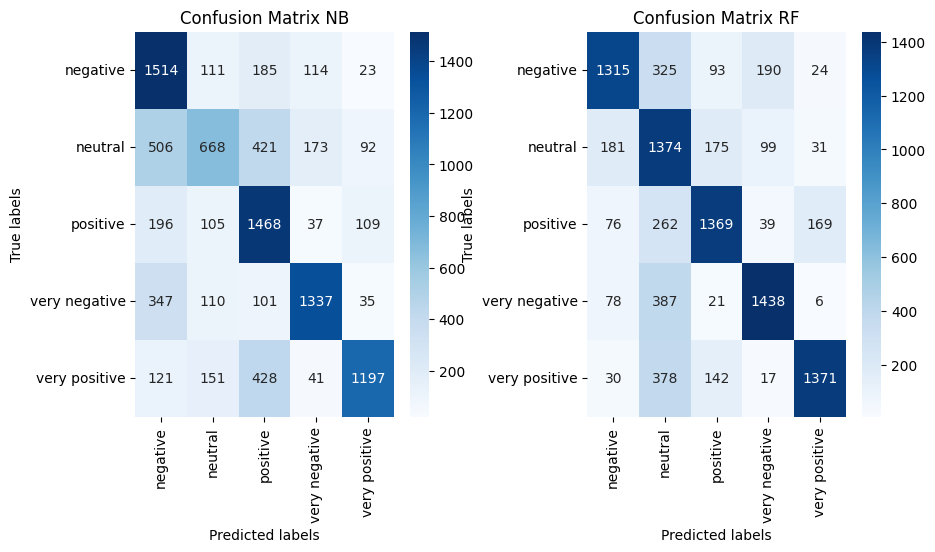

In [ ]:
# Importing Libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Create Plot
fig, axis = plt.subplots(1, 2, figsize=(10,5))

# Create Confusion Matrices
cm_nb = confusion_matrix(y_validation, y_pred)
cm_rf = confusion_matrix(y_validation, y_pred_rf)

# Plot Matrices
sns.heatmap(cm_nb, annot=True, cmap='Blues', fmt='g', xticklabels=['negative', 'neutral', 'positive', 'very negative', 'very positive'], yticklabels=['negative', 'neutral', 'positive', 'very negative', 'very positive'], ax=axis[0])
axis[0].set_xlabel('Predicted labels')
axis[0].set_ylabel('True labels')
axis[0].set_title('Confusion Matrix NB')

sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='g', xticklabels=['negative', 'neutral', 'positive', 'very negative', 'very positive'], yticklabels=['negative', 'neutral', 'positive', 'very negative', 'very positive'], ax=axis[1])
axis[1].set_xlabel('Predicted labels')
axis[1].set_ylabel('True labels')
axis[1].set_title('Confusion Matrix RF')

plt.subplots_adjust(wspace=0.4)

# Show Plot
plt.show()



## Perform the sentiment analysis

Now that we have finished training, we will start to analyse the sentiment of the harvested geotagged tweets. First, we will need to import the preprocessed data.

In [ ]:
# Importing Geotagged Tweets
tweet_file = '/gdrive/MyDrive/TwitterData_GroupB/Data/Preprocessed/tweets_text.csv'
tweets = pd.read_csv(tweet_file)

tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051 entries, 0 to 1050
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1051 non-null   int64 
 1   text    1051 non-null   object
dtypes: int64(1), object(1)
memory usage: 16.5+ KB


Then we need to clean the text and vectorize the tweets so that they can be fed to our model.

In [ ]:
# Set Tweet Text to String
tweets['text'] = tweets['text'].astype(str)
# Clean Tweets
tweets['clean_text'] = tweets['text'].apply(clean_text)
# Vectorise Tweets
tweets_vec = vectorizer.transform(tweets['clean_text'])

The tweets are now ready to be fed into our model.

In [ ]:
# Predict Sentiment of Tweets
tweet_sentiment = rf_model.predict(tweets_vec)

Next we need to add a column with the sentiment of the tweet.

In [ ]:
# Add Sentiment to Dataframe
tweets['sentiment'] = tweet_sentiment
# Drop Clean Text Column
tweets = tweets.drop('clean_text', axis=1)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051 entries, 0 to 1050
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1051 non-null   int64 
 1   text       1051 non-null   object
 2   sentiment  1051 non-null   object
dtypes: int64(1), object(2)
memory usage: 24.8+ KB


Since we also need to account for multiple engagement per receiver and sender pair, we will convert the sentiment labels back into numerical values. This will allow us to calculate the average sentiment of user interaction that occurs more frequently.

In [ ]:
def transform_sentiment_back(sentiment):
  if sentiment == 'very positive':
    return 1
  elif sentiment == 'positive':
    return 0.5
  elif sentiment == 'neutral':
    return 0
  elif sentiment == 'negative':
    return -0.5
  else: 
    return -1

tweets['sentiment_num'] = tweets['sentiment'].apply(transform_sentiment_back)

Now we have all the data for our analysis.

In [ ]:
tweets.head()

,id,text,sentiment,sentiment_num
0,1641769213462302721,@mirjamlederwerg Ik geloof het wel.,neutral,0.0
1,1641769076153368578,@mirjamlederwerg Die ken ik hier niet.,neutral,0.0
2,1641765800250843136,@MisterSenseo @MilfHummie Heel stom! Als ik we...,positive,0.5
3,1641760234489167873,@merchandise @SaschaJanssen @JaapFriso @MerelM...,neutral,0.0
4,1641756738385854465,@Pieterjanvl Maar ik was dus Vlaanderen aan he...,neutral,0.0


## Export the results

We can now store the dataframe to our directory and use it for our geospatial analysis.

In [ ]:
# Save Tweets Dataframe to Directory
tweets.to_csv('/gdrive/MyDrive/TwitterData_GroupB/Data/AnalysisData/Tweets.csv')

## Discussion

The training set was a very imbalanced set as the majority of the tweets were neutral. Therefore, the  dataset was reduced to almost 50,000 tweets, so that every sentiment was equally represented.

To maximize the performance of the classifiers, the tweet text needed to be cleaned to avoid feeding the models with noise. Therefore, some content of the tweets was removed. This included links, mentions, punctuations and other non-alphabetical characters, as well as stopwords. In addition, the words were stemmed and tokenized. Stemming is the process of reducing a word to its stem. For example, the words  ‘rennen, rende, rent’ are reduced to ‘ren’. This reduces the amount of features for our model, and thus computational efficiency, as all three words have the same meaning but just a different form.

A limitation of the approach described above is the lack of a spellchecker. This would have reduced the number of words, and also provided a more accurate model. However, there was no Dutch spell checker module for Python, and given the results it was not deemed necessary to build one. It was thought to only enhance the model slightly.

When comparing both models, we see that the NB model does a bad job at recalling neutral tweets (36%), whereas the RF model does a relatively good job (74%). On the other hand, the RF model is not very precise when it comes to neutral tweets (50%), where the NB scores a slightly higher precision of 55%. Overall, the RF model is much more robust and balanced, and thus this model is chosen for our sentiment analysis of the harvested tweets.

The use of the RF model introduces several limitations to our sentiment analysis. First, it is not perfect, having an accuracy of 71%. However, this is deemed to be good enough due to the high amount of training data. Second, the model has a precision of 50% for neutral tweets, indicating that it predicts a lot of false positives for this sentiment category. However, it seems as though the negative and positive sentiment categories are affected by these false positives as they both have roughly equal precision (78% and 76%, respectively) and recall (68% and 71%, respectively). The model does a good job in predicting sentiment on both ends of the spectrum, given its high precision scores.


